In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [20]:
df = pd.read_csv('traj.csv')

In [19]:
print(df.head())

   id                  time  entity_id  traj_id             coordinates  \
0   0  2013-10-08T17:45:00Z        254        0  [116.318726,40.009014]   
1   1  2013-10-08T17:46:45Z        254        0  [116.315102,40.004784]   
2   2  2013-10-08T17:47:39Z        254        0  [116.315018,40.002842]   
3   3  2013-10-08T17:49:26Z        254        0  [116.315041,39.998585]   
4   4  2013-10-08T17:51:15Z        254        0  [116.315605,39.992554]   

   current_dis   speeds  holidays  
0     0.000000  36.6900         0  
1     0.562623  24.5375         0  
2     0.778695  31.9675         0  
3     1.252148  19.7850         0  
4     1.924533  24.4500         0  


In [20]:
df.dtypes

id               int64
time            object
entity_id        int64
traj_id          int64
coordinates     object
current_dis    float64
speeds         float64
holidays         int64
dtype: object

In [21]:
# 将'coordinates'列转化为字符串
df['coordinates'] = df['coordinates'].astype(str)
# 提取浮点类型数据并分别存入两列
df[['end_longitude', 'end_latitude']] = df['coordinates'].str.strip('[]').str.split(',', expand=True).astype(float)
# 按照'traj_id'分组，并为每组添加新列'start_longitude'，‘start_latitude’
df['start_longitude'] = df.groupby('traj_id')['end_longitude'].transform('first')
df['start_latitude'] = df.groupby('traj_id')['end_latitude'].transform('first')
#speed转化为平均速度
df['speeds'] = df.groupby('traj_id')['speeds'].transform(lambda x: (x + x.iloc[0])/2)
#将'time'转化为时间戳，并计算每组相邻两行的时间戳差
df['time'] = pd.to_datetime(df['time'])
#df['time_diff'] = df.groupby('traj_id')['time'].diff().dt.total_seconds()
# 按照 "traj_id" 进行分组，计算和所在组第一行的时间戳的差
df['time_diff'] = df.groupby('traj_id')['time'].transform(lambda x: (x - x.iloc[0]).dt.total_seconds())

print(df)

            id                      time  entity_id  traj_id  \
0            0 2013-10-08 17:45:00+00:00        254        0   
1            1 2013-10-08 17:46:45+00:00        254        0   
2            2 2013-10-08 17:47:39+00:00        254        0   
3            3 2013-10-08 17:49:26+00:00        254        0   
4            4 2013-10-08 17:51:15+00:00        254        0   
...        ...                       ...        ...      ...   
414839  518403 2013-10-30 23:14:35+00:00       4954    21998   
414840  518404 2013-10-30 23:14:59+00:00       4954    21998   
414841  518405 2013-10-30 23:16:35+00:00       4954    21998   
414842  518406 2013-10-30 23:16:59+00:00       4954    21998   
414843  518407 2013-10-30 23:17:11+00:00       4954    21998   

                   coordinates  current_dis    speeds  holidays  \
0       [116.318726,40.009014]     0.000000  36.69000         0   
1       [116.315102,40.004784]     0.562623  30.61375         0   
2       [116.315018,40.002842]

In [22]:
# 删除id,time和coordinates列
column_to_remove = 'id'
df = df.drop(columns=[column_to_remove])
column_to_remove = 'time'
df = df.drop(columns=[column_to_remove])
column_to_remove = 'coordinates'
df = df.drop(columns=[column_to_remove])
# 查找特定列中的空值并将其设为0
column_to_fill = 'time_diff'
df[column_to_fill].fillna(0, inplace=True)
# 将修改后的数据保存到新的CSV文件
df.to_csv('new.csv', index=False)

In [23]:
# 读取CSV文件
data = pd.read_csv('new.csv')

In [24]:
%matplotlib inline

In [25]:
data.shape

(414844, 10)

In [26]:
# 选择多个列作为特征
selected_features = ['entity_id', 'current_dis','speeds','holidays','end_longitude','end_latitude','start_longitude','start_latitude']
X = df[selected_features]
# 选择目标列作为标签
y = df['time_diff']
# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#随机森林模型（已弃用）
rf = RandomForestRegressor()
rf = rf.fit(X_train, y_train)
# 评估模型性能
accuracy = rf.score(X_test, y_test)
print(f"模型准确率: {accuracy}")

模型准确率: 0.9071668071092857


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# 读取CSV文件
data = pd.read_csv('new.csv')
# 选择多个列作为特征
selected_features = ['entity_id', 'current_dis','speeds','holidays','end_longitude','end_latitude','start_longitude','start_latitude']
X = data[selected_features]
# 选择目标列作为标签
y = data['time_diff']
# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#随机搜索调参
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
param_dist = {
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [300,400,500,600]
}
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   cv=3, random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters: ", random_search.best_params_)
print("Best CV Score (neg_mean_squared_error): ", random_search.best_score_)

Best Parameters:  {'subsample': 0.9, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV Score (neg_mean_squared_error):  -24396.786472472235


In [7]:
#xgboost模型（效果最好，最终选用）
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# 使用rmse评估模型性能
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
rmse_scorer = make_scorer(rmse, greater_is_better=False)
xg = xgb.XGBRegressor(subsample= 0.9, n_estimators=600, max_depth=10, learning_rate= 0.1, colsample_bytree= 0.8)
cv_results = cross_val_score(xg, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=rmse_scorer)
rmse_scores = -cv_results  
for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1}: RMSE = {score}")

average_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE: {average_rmse}")

Fold 1: RMSE = 147.15159556647757
Fold 2: RMSE = 146.93124636662054
Fold 3: RMSE = 146.03872857888342
Fold 4: RMSE = 146.28893065499562
Fold 5: RMSE = 149.76896212348137

Average RMSE: 147.2358926580917


In [10]:
#xgboost模型
import numpy as np
import xgboost as xgb
xg = xgb.XGBRegressor(subsample= 0.9, n_estimators=600, max_depth=10, learning_rate= 0.1, colsample_bytree= 0.8)
xg.fit(X_train, y_train)
# 准确率参考
accuracy = xg.score(X_test, y_test)
print(f"模型准确率: {accuracy}")

模型准确率: 0.9780593658123551


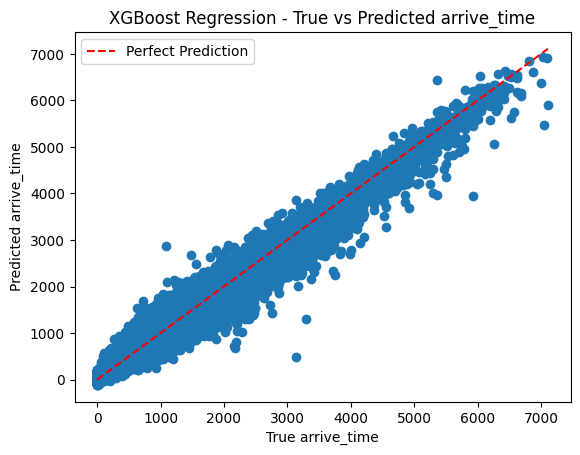

In [11]:
import matplotlib.pyplot as plt
y_pred = xg.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.xlabel('True arrive_time')
plt.ylabel('Predicted arrive_time')
plt.title('XGBoost Regression - True vs Predicted arrive_time')
plt.legend()
plt.show()

In [30]:
#对eta_task进行数据处理
import pandas as pd
import numpy as np
task = pd.read_csv('eta_task.csv')

In [31]:
# 将'coordinates'列转化为字符串
task['coordinates'] = task['coordinates'].astype(str)
# 提取浮点类型数据并分别存入两列
task[['end_longitude', 'end_latitude']] = task['coordinates'].str.strip('[]').str.split(',', expand=True).astype(float)
# 按照'traj_id'分组，并为每组添加新列'start_longitude'，‘start_latitude’
task['start_longitude'] = task.groupby('traj_id')['end_longitude'].transform('last')
task['start_latitude'] = task.groupby('traj_id')['end_latitude'].transform('last')
# 设置距离
task['current_dis'] = task.groupby('traj_id')['current_dis'].transform('last')
#求平均速度
# 按 'traj_id' 分组，计算每组第一行和最后一行 'speeds' 的平均值
task['speeds'] = (task.groupby('traj_id')['speeds'].transform('first') + task.groupby('traj_id')['speeds'].transform('last'))*0.5
#将'time'转化为时间戳
task['time'] = pd.to_datetime(task['time'])
task['timestamp_column'] = task['time'].astype(np.int64) // 10**9
# 删除每组的最后一行
task= task.groupby('traj_id').apply(lambda x: x.iloc[:-1])
# 将修改后的数据保存到新的CSV文件
task.to_csv('modified.csv', index=False)
print(task.head(13))
task.dtypes


              id  traj_id                      time  entity_id  \
traj_id                                                          
9       0    126        9 2013-10-08 22:30:00+00:00        254   
11      2    147       11 2013-10-08 23:00:00+00:00        254   
13      4    171       13 2013-10-08 17:15:00+00:00        255   
16      6    207       16 2013-10-08 19:00:00+00:00        255   
24      8    337       24 2013-10-08 08:00:00+00:00        256   
25      10   355       25 2013-10-08 08:30:00+00:00        256   
40      12   547       40 2013-10-08 08:30:00+00:00        257   
53      14  1040       53 2013-10-08 18:30:00+00:00        257   
55      16  1103       55 2013-10-08 19:45:00+00:00        257   
60      18  1191       60 2013-10-08 06:15:00+00:00        258   
67      20  1439       67 2013-10-08 06:00:00+00:00       4118   
77      22  1656       77 2013-10-08 13:45:00+00:00       4118   
82      24  1707       82 2013-10-08 09:30:00+00:00       4120   

         

id                                int64
traj_id                           int64
time                datetime64[ns, UTC]
entity_id                         int64
coordinates                      object
current_dis                     float64
speeds                          float64
holidays                          int64
end_longitude                   float64
end_latitude                    float64
start_longitude                 float64
start_latitude                  float64
timestamp_column                  int64
dtype: object

In [22]:
# 读取CSV文件
df = pd.read_csv('new.csv')
# 筛选出 'holidays' 列值为 0 的行
holiday_df = df[df['holidays'] == 1]
workday_df = df[df['holidays'] == 0]
# 将筛选结果保存到新的CSV文件
holiday_df.to_csv('holiday.csv', index=False)
workday_df.to_csv('workday.csv', index=False)

In [23]:
#节假日场景评估
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# 读取CSV文件
df = pd.read_csv('holiday.csv')
# 选择多个列作为特征
selected_features = ['entity_id', 'current_dis','speeds','holidays','end_longitude','end_latitude','start_longitude','start_latitude']
X = df[selected_features]
# 选择目标列作为标签
y = df['time_diff']
# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 使用rmse评估模型性能
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
rmse_scorer = make_scorer(rmse, greater_is_better=False)
xg = xgb.XGBRegressor(subsample= 0.9, n_estimators=600, max_depth=10, learning_rate= 0.1, colsample_bytree= 0.8)
cv_results = cross_val_score(xg, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=rmse_scorer)
rmse_scores = -cv_results  # 取反因为Scikit-learn通常使用"greater is better"规则
for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1}: RMSE = {score}")

average_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE: {average_rmse}")

Fold 1: RMSE = 134.3392007593114
Fold 2: RMSE = 127.77070173119168
Fold 3: RMSE = 130.0800371175413
Fold 4: RMSE = 131.14678934315407
Fold 5: RMSE = 128.79323246129067

Average RMSE: 130.42599228249782


In [24]:
#工作日场景评估
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# 读取CSV文件
df = pd.read_csv('workday.csv')
# 选择多个列作为特征
selected_features = ['entity_id', 'current_dis','speeds','holidays','end_longitude','end_latitude','start_longitude','start_latitude']
X = df[selected_features]
# 选择目标列作为标签
y = df['time_diff']
# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 使用rmse评估模型性能
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
rmse_scorer = make_scorer(rmse, greater_is_better=False)
xg = xgb.XGBRegressor(subsample= 0.9, n_estimators=600, max_depth=10, learning_rate= 0.1, colsample_bytree= 0.8)
cv_results = cross_val_score(xg, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=rmse_scorer)
rmse_scores = -cv_results  # 取反因为Scikit-learn通常使用"greater is better"规则
for i, score in enumerate(rmse_scores):
    print(f"Fold {i+1}: RMSE = {score}")

average_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE: {average_rmse}")

Fold 1: RMSE = 136.90461391076116
Fold 2: RMSE = 140.98394234400305
Fold 3: RMSE = 139.6431950049868
Fold 4: RMSE = 139.8848341719177
Fold 5: RMSE = 144.2995122114143

Average RMSE: 140.3432195286166
